# Summary
* Purpose: Compute beam for AgBiSe2 CNCS dataset. 

# Tools

In [1]:
pwd

u'/SNS/users/lj7/simulations/CNCS/AgBiSe2'

** Modify the workdir !!! **

In [2]:
workdir = "/SNS/users/lj7/simulations/CNCS/AgBiSe2/Ei3.5-beam/"

In [3]:
mkdir -p {workdir}

In [4]:
cd {workdir}

/SNS/users/lj7/simulations/CNCS/AgBiSe2/Ei3.5-beam


In [5]:
# %matplotlib notebook
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np, os, glob
import histogram.hdf as hh, histogram as H

In [6]:
!which mcvine

/home/lj7/dv/mcvine/export/bin/mcvine


In [7]:
import mcvine.cli

# Beam

** Options for the beam simulation **

In [9]:
!mcvine instruments cncs beam --help-properties

properties of 'cncs_beam':
    E=<float>: desired incident beam energy. unit: meV
        default value: 20
        current value: 20.0, from {default}
    dumpconfiguration=<bool>: If set, dump configuration to a pml file
        default value: 0
        current value: False, from {default}
    dumpconfiguration-output=<str>: Output file path of dumped configuration file (pml)
        default value: ''
        current value: '', from {default}
    f1=<float>: Chopper freq 1. unit: Hz
        default value: 60
        current value: 60.0, from {default}
    f2=<float>: Chopper freq 2. unit: Hz
        default value: 60
        current value: 60.0, from {default}
    f3=<float>: Chopper freq 3. unit: Hz
        default value: 60
        current value: 60.0, from {default}
    f41=<float>: Chopper freq 41. unit: Hz
        default value: 300
        current value: 300.0, from {default}
    f42=<float>: Chopper freq 42. unit: Hz
        default value: 300
        current value: 300.0, fro

In [15]:
# Ei=3.5, highflux mode

Fluxmode:
* High Flux (HF) = 9.0 deg
* Intermediate (AI) = 4.4 deg
* High Res (HR) = 2.0 deg

In [11]:
%%time
!mcvine instruments cncs beam -E=3.5 -f1=60 -f2=60 -f3=60 -f41=300 -f42=300 -ncount=1e9 -fluxmode=9.0 -nodes=20 >log.sim

/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/AbstractComponent.py:40: UserWarning: In NeutronToStorage: Deprecated. should use self.simulation_context.overwrite_datafiles
  warnings.warn(msg)
/SNS/software/miniconda2/envs/mcvine-unstable/lib/python2.7/site-packages/mcni/AbstractComponent

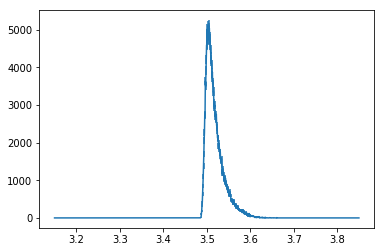

In [12]:
H.plot(hh.load('out/ienergy.h5'))

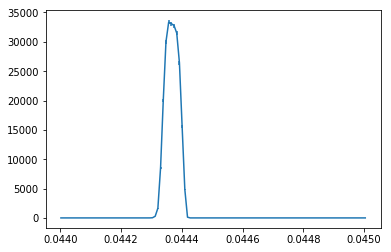

In [17]:
H.plot(hh.load('out/itof.h5')[(0.044, 0.045)])

In [18]:
ls out

ienergy.h5  ix_divx.h5  ix_y.h5     iy_divy.h5  props.json
itof.h5     ix_divy.h5  iy_divx.h5  neutrons    rank0-step0/


In [19]:
cat out/props.json

{'emission time': '167.007017183 microsecond', 'flux': '238266.231197 counts per 34kJ pulse', 'tof fwhm': '53.1803008741 microsecond', 'average tof': '44368.0610301 microsecond', 'average energy': '3.51837301574 meV'}

In [20]:
!mcvine-neutron-storage-count-neutrons out/neutrons

107360


In [15]:
d=eval(open('out/props.json').read())
Ei = float(d['average energy'].split()[0])
t0 = float(d['emission time'].split()[0])
print Ei, t0

3.51837301574 167.007017183


# Compare to experiment

In [8]:
path = '/SNS/CNCS/IPTS-18124/data/CNCS_214437_event.nxs'

In [9]:
from mantid import simpleapi as msa, mtd

/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/mantid/kernel/__init__.py:14: RuntimeWarning: to-Python converter for std::vector<int, std::allocator<int> > already registered; second conversion method ignored.
  from ._kernel import *
/home/lj7/miniconda2/envs/dev-mcvine/lib/python2.7/site-packages/mantid/kernel/__init__.py:14: RuntimeWarning: to-Python converter for std::vector<double, std::allocator<double> > already registered; second conversion method ignored.
  from ._kernel import *


In [10]:
ws = msa.Load(path, LoadMonitors=True)

In [11]:
m = ws[1]

In [12]:
m

Workspace2D
Title: PbSe 300K HF 002-point#01/41
Histograms: 2
Bins: 200001
Histogram
X axis: Time-of-flight / microsecond
Y axis: Counts
Distribution: False
Instrument: CNCS (2017-Mar-14 to 2100-Jan-31)Instrument from: /home/lj7/.mantid/instrument/CNCS_Definition.xml

Parameters from: /home/lj7/miniconda2/envs/dev-mcvine/instrument/CNCS_Parameters.xml
Run start: 2017-Apr-13 21:09:42
Run end:  2017-Apr-13 21:13:45

In [13]:
x = m.extractX()
y = m.extractY()

In [16]:
L = 36.262-1.416

from mcni.utils import conversion as Conv
v = Conv.e2v(Ei)
t = L/v*1e6 + t0
print t

42639.705234


(42539.705233968838, 42789.705233968838)

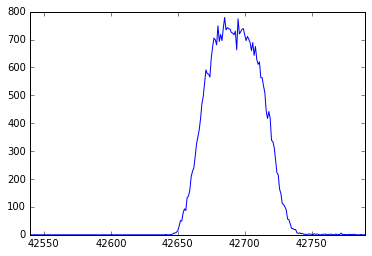

In [17]:
plt.plot(x[1][:-1], y[1])
plt.xlim(t-100, t+150)

In [18]:
itof_at_sample = hh.load('out/itof.h5')[(0.044, 0.045)]

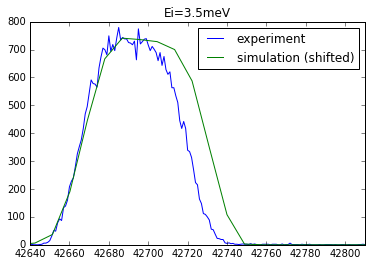

In [25]:
plt.title('Ei=3.5meV')
plt.plot(x[1][:-1], y[1], label='experiment')
plt.plot(itof_at_sample.tof*1e6 - 1670, itof_at_sample.I/45, label='simulation (shifted)')
plt.xlim(42640, 42810)
plt.legend()